## Importing Necessary packages

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import numpy as np
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans




## Loading the data

In [3]:
data_path = os.path.join(os.getcwd(), 'data\sales_data_sample.csv')
data = pd.read_csv(data_path, encoding='iso-8859-1')
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'])
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

As can be seen in the above output the columns: ADDRESSLINE2, STATE, POSTALCODE and TERRITORY have null data, but these columns are not defining for the segmentation of the clusters

# EDA

# Univariate analysis

Text(0.5, 1.0, 'Distribution of the price of each solded product')

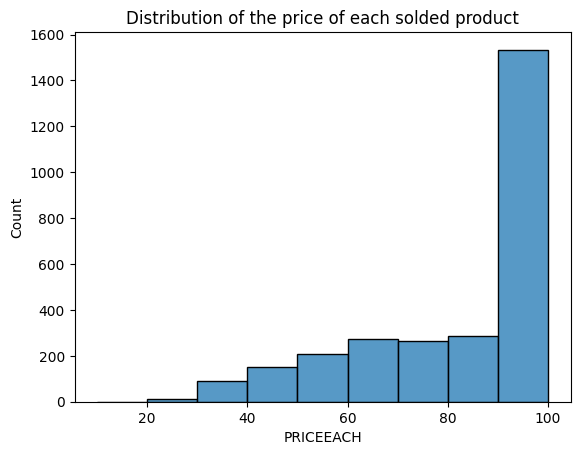

In [5]:
sns.histplot(data=data, x="PRICEEACH", bins=list(range(10,110,10)))
plt.title("Distribution of the price of each solded product")

Text(0.5, 1.0, 'Distribution of the DEALSIZE')

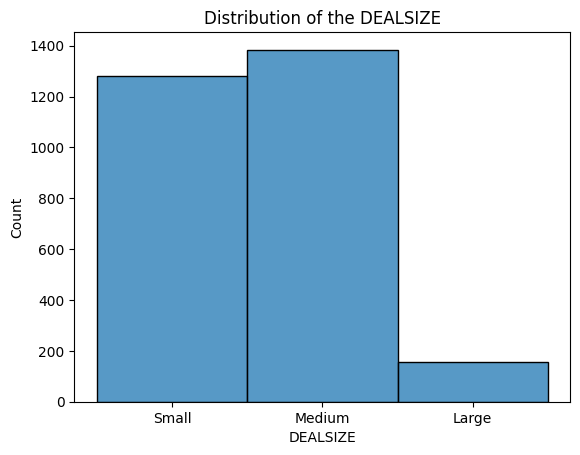

In [6]:
sns.histplot(data=data, x="DEALSIZE")
plt.title("Distribution of the DEALSIZE")


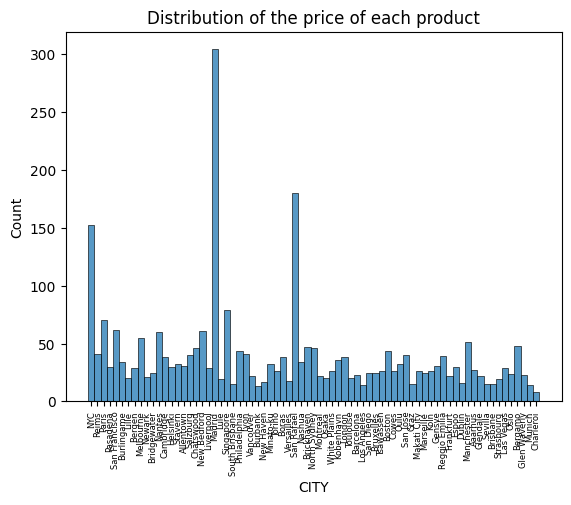

In [7]:
sns.histplot(data=data, x="CITY")
plt.title("Distribution of the price of each product")
plt.xticks(rotation=90, fontsize=6)
plt.show()

# RFM Analysis

As the data is very old, the RFM analysis will work under the assumption that the current date is the date on which the last sale was made, so the actual year is 2005 and the last year for the frequency and monetary characteristics is 2004.
The following code is computing the recency, frequency, and monetary value for each customer using the following steps:

1. The `last_order_date` variable is set to the maximum value of the `ORDERDATE` column in the `data` DataFrame, which represents the date of the last order in the dataset.

2. The `current_date` variable is set to the same value as `last_order_date`, which assumes that the current date is the date on which the last sale was made.

3. The `last_year` variable is calculated as one year ago from the `current_date`, which is used to filter the data for the last year of sales in the dataset.

4. Three new columns are created in the `data` DataFrame: `RECENCY_days`, `FREQUENCY_last_year`, and `MONETARY_last_year`. These columns will be used to store the recency, frequency, and monetary value for each customer, respectively.

5. The `recency_quantity` variable is created by grouping the `data` DataFrame by `CUSTOMERNAME` and applying a lambda function to the `ORDERDATE` column that calculates the number of days between the `current_date` and the maximum order date for each customer(this says how long it has been since the customer placed their last order). This results in a DataFrame that contains the recency value for each customer.

6. The `frecuency_monetary_ordered_last_year` variable is created by filtering the `data` DataFrame to include only the rows where the `ORDERDATE` is greater than or equal to `last_year`, grouping the resulting DataFrame by `CUSTOMERNAME`, and applying a lambda function to three columns: `FREQUENCY_last_year`, `MONETARY_last_year`, and `QUANTITYORDERED`. The `FREQUENCY_last_year` column is used to calculate the frequency of orders (i.e., the number of unique order numbers), the `MONETARY_last_year` column is used to calculate the monetary value of orders (i.e., the sum of sales), and the `QUANTITYORDERED` column is used to calculate the total quantity ordered in the last year.

7. The `recency_quantity` and `frecuency_monetary_ordered_last_year` DataFrames are concatenated along the column axis using `pd.concat()` to create a new DataFrame called `rfm_data`. This DataFrame contains the recency, frequency, monetary value, and quantity ordered data for each customer.

8. Any missing values in `rfm_data` are filled with 0 using the `fillna()` method. The missing values 


In [14]:
# Getting the last order date from the 'data' DataFrame
last_order_date: dt.datetime = max(data["ORDERDATE"])

# Assuming that the current date is the date on which the last sale was made
current_date: dt.datetime = last_order_date

# Calculating the date that was one year ago from the current date, this date will be used to filter the data from the current date to the last year to analyze the RFM
last_year = current_date - dt.timedelta(days=365)

# Creating new columns in the 'data' DataFrame for the RFM analysis
data["RECENCY_days"] = data["ORDERDATE"].copy() 
data["FREQUENCY_last_year"] = data["ORDERNUMBER"].copy()
data["MONETARY_last_year"] = data["SALES"].copy()

# Calculating the recency for each customer
recency_quantity = data.groupby(by='CUSTOMERNAME').agg({"RECENCY_days": lambda order_dates: (current_date - order_dates.max()).days})

# Calculating the frequency, monetary value, and quantity ordered in the last year for each customer
frecuency_monetary_ordered_last_year = data[data["ORDERDATE"] >= last_year].groupby('CUSTOMERNAME').agg({"FREQUENCY_last_year": lambda order_number: len(order_number.unique()),
                                                                                                 "MONETARY_last_year": lambda sales: sales.sum(),
                                                                                                 "QUANTITYORDERED": lambda quantity: int(quantity.sum())})

# Renaming the 'QUANTITYORDERED' column to 'QUANTITYORDERED_last_year'
frecuency_monetary_ordered_last_year.rename(columns={"QUANTITYORDERED": "QUANTITYORDERED_last_year"}, inplace=True)

# Concatenating the recency, frequency, monetary, and quantity data into a single DataFrame for the RFM analysis
rfm_data = pd.concat([recency_quantity, frecuency_monetary_ordered_last_year], axis=1)

# Filling any missing values with 0
rfm_data.fillna(0, inplace=True)

# Bivariate Analysis

In [9]:
customers = data["CUSTOMERNAME"].unique().tolist()
print(f"There are {len(customers)} customers")


There are 92 customers
